In [1]:
!pip install -q kagglehub pandas numpy


In [2]:
import pandas as pd
import numpy as np

import kagglehub
from kagglehub import KaggleDatasetAdapter


Load the dataset (IMPORTANT)

In [3]:
import kagglehub

DATASET_NAME = "shudhanshusingh/az-medicine-dataset-of-india"

# Download dataset locally
dataset_path = kagglehub.dataset_download(DATASET_NAME)

print("Dataset downloaded to:", dataset_path)

# List files
import os
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        print(file)

100%|██████████| 6.60M/6.60M [00:00<00:00, 62.3MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/shudhanshusingh/az-medicine-dataset-of-india/versions/1
A_Z_medicines_dataset_of_India.csv


In [4]:
import pandas as pd
from kagglehub import KaggleDatasetAdapter
import kagglehub

DATASET_NAME = "shudhanshusingh/az-medicine-dataset-of-india"
FILE_NAME = "A_Z_medicines_dataset_of_India.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    DATASET_NAME,
    FILE_NAME
)

print("Dataset loaded successfully")


Using Colab cache for faster access to the 'az-medicine-dataset-of-india' dataset.
Dataset loaded successfully


In [5]:
df.head()
df.shape
list(df.columns)
df.info()
(df.isnull().mean() * 100).sort_values(ascending=False).head(15)
df_raw = df.copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253973 entries, 0 to 253972
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  253973 non-null  int64  
 1   name                253973 non-null  object 
 2   price(₹)            253973 non-null  float64
 3   Is_discontinued     253973 non-null  bool   
 4   manufacturer_name   253973 non-null  object 
 5   type                253973 non-null  object 
 6   pack_size_label     253973 non-null  object 
 7   short_composition1  253973 non-null  object 
 8   short_composition2  112171 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 15.7+ MB


In [6]:
df.drop(columns=['id'], inplace=True)


In [7]:
df.rename(columns={
    'price(₹)': 'price',
    'Is_discontinued': 'is_discontinued',
    'manufacturer_name': 'manufacturer',
    'short_composition1': 'composition_1',
    'short_composition2': 'composition_2'
}, inplace=True)


In [8]:
text_cols = [
    'name', 'manufacturer', 'type',
    'pack_size_label', 'composition_1', 'composition_2'
]

for col in text_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.lower()
        .str.strip()
    )


In [9]:
df['composition_2'] = df['composition_2'].replace('nan', np.nan)


In [10]:
df['available'] = (~df['is_discontinued']).astype(int)


In [11]:
brand_count = df.groupby('composition_1')['name'].nunique()
df['brands_per_composition'] = df['composition_1'].map(brand_count)


In [12]:
avg_price = df.groupby('composition_1')['price'].mean()
df['avg_composition_price'] = df['composition_1'].map(avg_price)


In [13]:
df['overpriced'] = (df['price'] > 1.5 * df['avg_composition_price']).astype(int)


In [14]:
df[['price', 'avg_composition_price']].describe()
df['overpriced'].value_counts(normalize=True)
df['available'].value_counts(normalize=True)


,proportion
available,
1,0.968875
0,0.031125


In [15]:
df.head()
df.shape
list(df.columns)
df.info()
(df.isnull().mean() * 100).sort_values(ascending=False).head(15)
df_raw = df.copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253973 entries, 0 to 253972
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   name                    253973 non-null  object 
 1   price                   253973 non-null  float64
 2   is_discontinued         253973 non-null  bool   
 3   manufacturer            253973 non-null  object 
 4   type                    253973 non-null  object 
 5   pack_size_label         253973 non-null  object 
 6   composition_1           253973 non-null  object 
 7   composition_2           112171 non-null  object 
 8   available               253973 non-null  int64  
 9   brands_per_composition  253973 non-null  int64  
 10  avg_composition_price   253973 non-null  float64
 11  overpriced              253973 non-null  int64  
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 21.6+ MB


In [16]:
high_risk_discontinued = (
    df[df['available'] == 0]
    .groupby('composition_1')
    .agg(
        discontinued_brands=('name', 'nunique'),
        avg_price=('price', 'mean'),
        manufacturers=('manufacturer', 'nunique')
    )
    .sort_values(by='discontinued_brands', ascending=False)
)

high_risk_discontinued.head(15)


,discontinued_brands,avg_price,manufacturers
composition_1,,,
aceclofenac (100mg),95,61.610842,54
cefixime (200mg),91,152.731868,54
amlodipine (5mg),77,64.133896,40
glimepiride (2mg),73,103.972297,37
glimepiride (1mg),67,77.937794,35
ofloxacin (200mg),65,67.315077,40
telmisartan (40mg),63,104.899683,31
atorvastatin (10mg),63,88.641250,32
domperidone (30mg),60,84.086667,41


In [17]:
price_median = df['price'].median()

critical_discontinued = high_risk_discontinued.query(
    "discontinued_brands >= 5 and manufacturers <= 3 and avg_price > @price_median"
)

critical_discontinued.head(15)


,discontinued_brands,avg_price,manufacturers
composition_1,,,
voriconazole (200mg),6,2314.083333,3
formoterol (12mcg),6,245.666667,3
fluticasone propionate (50mcg),5,255.514000,3
oxetacaine (10mg/5ml),5,136.306000,3
teneligliptin (20mg),5,135.833333,3
mupirocin (2% w/w),5,188.880000,3


In [18]:
critical_discontinued.shape


(6, 3)

In [19]:
critical_discontinued['discontinued_brands'].sum()
replacement_strength = (
    df[(df['available'] == 1)]
    .groupby('composition_1')
    .agg(
        available_brands=('name', 'nunique'),
        min_price=('price', 'min'),
        avg_price=('price', 'mean')
    )
)

replacement_strength.head()


,available_brands,min_price,avg_price
composition_1,,,
abacavir (300mg),3,1550.64,3451.213333
abacavir (600mg),5,1486.00,2986.365000
abatacept (250mg),1,30000.00,30000.000000
abciximab (10mg),2,8100.00,15364.500000
abemaciclib (100mg),1,11938.00,11938.000000


ML features


In [20]:
ml_df = (
    df.groupby('composition_1')
    .agg(
        avg_price=('price', 'mean'),
        max_price=('price', 'max'),
        brands=('name', 'nunique'),
        manufacturers=('manufacturer', 'nunique'),
        discontinued_ratio=('available', lambda x: 1 - x.mean()),
        overpriced_ratio=('overpriced', 'mean')
    )
    .reset_index()
)


Prepare data for ML

In [21]:
from sklearn.preprocessing import StandardScaler

features = [
    'avg_price',
    'max_price',
    'brands',
    'manufacturers',
    'discontinued_ratio',
    'overpriced_ratio'
]

X = ml_df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Build the ML model

In [22]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # top 5% risky
    random_state=42
)

ml_df['risk_label'] = iso.fit_predict(X_scaled)


Convert to a meaningful risk score

In [23]:
ml_df['risk_score'] = -iso.decision_function(X_scaled)


In [24]:
ml_df.sort_values(by='risk_score', ascending=False).head(15)


,composition_1,avg_price,max_price,brands,manufacturers,discontinued_ratio,overpriced_ratio,risk_label,risk_score
2647,eptacog alfa (2mg),91500.000000,91500.00,1,1,1.000000,0.000000,-1,0.218386
577,atezolizumab (60mg/ml),396725.000000,396725.00,1,1,0.000000,0.000000,-1,0.198094
2449,domperidone (30mg),93.370481,314.35,5082,3254,0.011689,0.047536,-1,0.192486
27,aceclofenac (100mg),78.236643,562.60,7178,2932,0.013152,0.151045,-1,0.191307
3621,inotuzumab ozogamacin (1mg),330000.000000,330000.00,1,1,0.000000,0.000000,-1,0.190880
1266,cefixime (200mg),160.292088,1126.73,5189,2261,0.017396,0.095775,-1,0.190211
4058,levocetirizine (5mg),75.213856,370.00,4186,2554,0.012947,0.169021,-1,0.189506
4247,lorlatinib (100mg),312000.000000,312000.00,1,1,0.000000,0.000000,-1,0.188906
578,atezolizumab (840mg),277708.000000,277708.00,1,1,0.000000,0.000000,-1,0.188658
5952,ramucirumab (500mg),257532.000000,257532.00,1,1,0.000000,0.000000,-1,0.188162


evaluation


In [25]:
ml_df[ml_df['brands'] <= 2].sort_values('risk_score', ascending=False).head(10)


,composition_1,avg_price,max_price,brands,manufacturers,discontinued_ratio,overpriced_ratio,risk_label,risk_score
2647,eptacog alfa (2mg),91500.00,91500.0,1,1,1.0,0.0,-1,0.218386
577,atezolizumab (60mg/ml),396725.00,396725.0,1,1,0.0,0.0,-1,0.198094
3621,inotuzumab ozogamacin (1mg),330000.00,330000.0,1,1,0.0,0.0,-1,0.190880
4247,lorlatinib (100mg),312000.00,312000.0,1,1,0.0,0.0,-1,0.188906
578,atezolizumab (840mg),277708.00,277708.0,1,1,0.0,0.0,-1,0.188658
5952,ramucirumab (500mg),257532.00,257532.0,1,1,0.0,0.0,-1,0.188162
5445,pertuzumab (30mg/ml),255150.00,255150.0,1,1,0.0,0.0,-1,0.187418
108,ado-trastuzumab emtansine (160mg),248937.00,248937.0,1,1,0.0,0.0,-1,0.187418
5065,octreotide acetate (30mg),48623.75,75447.5,2,2,0.0,0.5,-1,0.184870
5396,pembrolizumab (100mg),236500.00,236500.0,1,1,0.0,0.0,-1,0.183317


K-Means Clustering

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
ml_df['cluster'] = kmeans.fit_predict(X_scaled)


In [27]:
ml_df.head()

,composition_1,avg_price,max_price,brands,manufacturers,discontinued_ratio,overpriced_ratio,risk_label,risk_score,cluster
0,abacavir (300mg),3287.450,7215.00,4,4,0.250000,0.250000,1,-0.012614,1
1,abacavir (600mg),2986.365,5832.85,5,4,0.000000,0.166667,1,-0.116000,1
2,abatacept (250mg),30000.000,30000.00,1,1,0.000000,0.000000,-1,0.006223,1
3,abciximab (10mg),13343.000,22629.00,3,3,0.333333,0.333333,-1,0.096266,1
4,abemaciclib (100mg),11938.000,11938.00,1,1,0.000000,0.000000,1,-0.101850,1


In [28]:
ml_df.sort_values(by='risk_score', ascending=False).head(15)


,composition_1,avg_price,max_price,brands,manufacturers,discontinued_ratio,overpriced_ratio,risk_label,risk_score,cluster
2647,eptacog alfa (2mg),91500.000000,91500.00,1,1,1.000000,0.000000,-1,0.218386,0
577,atezolizumab (60mg/ml),396725.000000,396725.00,1,1,0.000000,0.000000,-1,0.198094,2
2449,domperidone (30mg),93.370481,314.35,5082,3254,0.011689,0.047536,-1,0.192486,3
27,aceclofenac (100mg),78.236643,562.60,7178,2932,0.013152,0.151045,-1,0.191307,3
3621,inotuzumab ozogamacin (1mg),330000.000000,330000.00,1,1,0.000000,0.000000,-1,0.190880,2
1266,cefixime (200mg),160.292088,1126.73,5189,2261,0.017396,0.095775,-1,0.190211,3
4058,levocetirizine (5mg),75.213856,370.00,4186,2554,0.012947,0.169021,-1,0.189506,3
4247,lorlatinib (100mg),312000.000000,312000.00,1,1,0.000000,0.000000,-1,0.188906,2
578,atezolizumab (840mg),277708.000000,277708.00,1,1,0.000000,0.000000,-1,0.188658,2
5952,ramucirumab (500mg),257532.000000,257532.00,1,1,0.000000,0.000000,-1,0.188162,2


Confirm logical vapidity



In [29]:
ml_df[
    (ml_df['brands'] <= 2) &
    (ml_df['avg_price'] > ml_df['avg_price'].median())
].sort_values('risk_score', ascending=False).head(10)


,composition_1,avg_price,max_price,brands,manufacturers,discontinued_ratio,overpriced_ratio,risk_label,risk_score,cluster
2647,eptacog alfa (2mg),91500.00,91500.0,1,1,1.0,0.0,-1,0.218386,0
577,atezolizumab (60mg/ml),396725.00,396725.0,1,1,0.0,0.0,-1,0.198094,2
3621,inotuzumab ozogamacin (1mg),330000.00,330000.0,1,1,0.0,0.0,-1,0.190880,2
4247,lorlatinib (100mg),312000.00,312000.0,1,1,0.0,0.0,-1,0.188906,2
578,atezolizumab (840mg),277708.00,277708.0,1,1,0.0,0.0,-1,0.188658,2
5952,ramucirumab (500mg),257532.00,257532.0,1,1,0.0,0.0,-1,0.188162,2
5445,pertuzumab (30mg/ml),255150.00,255150.0,1,1,0.0,0.0,-1,0.187418,2
108,ado-trastuzumab emtansine (160mg),248937.00,248937.0,1,1,0.0,0.0,-1,0.187418,2
5065,octreotide acetate (30mg),48623.75,75447.5,2,2,0.0,0.5,-1,0.184870,1
5396,pembrolizumab (100mg),236500.00,236500.0,1,1,0.0,0.0,-1,0.183317,2


In [30]:
ml_df['log_avg_price'] = np.log1p(ml_df['avg_price'])
ml_df['log_max_price'] = np.log1p(ml_df['max_price'])

features = [
    'log_avg_price',
    'log_max_price',
    'brands',
    'manufacturers',
    'discontinued_ratio',
    'overpriced_ratio'
]

X = ml_df[features]
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42
)

ml_df['risk_label'] = iso.fit_predict(X_scaled)
ml_df['risk_score'] = -iso.decision_function(X_scaled)


In [31]:
import gradio as gr
import pandas as pd
import numpy as np

def analyze_medicine(med_name):
    med_name = med_name.lower().strip()

    # Find medicine
    med_row = df[df['name'].str.contains(med_name, na=False)]

    if med_row.empty:
        return "Medicine not found in dataset.", None

    med = med_row.iloc[0]
    composition = med['composition_1']

    # Composition-level stats
    comp_stats = ml_df[ml_df['composition_1'] == composition]

    if comp_stats.empty:
        return "Composition statistics not available.", None

    comp = comp_stats.iloc[0]

    # Price comparison
    price_diff = med['price'] - comp['avg_price']
    price_flag = "Overpriced" if med['price'] > 1.5 * comp['avg_price'] else "Within market range"

    # Text summary (THIS IS WHAT YOU EXPLAIN IN VIVA)
    summary = f"""
Medicine Name: {med['name']}
Composition: {composition}

Brand Price: ₹{med['price']:.2f}
Average Market Price (Composition): ₹{comp['avg_price']:.2f}
Price Status: {price_flag}

Brands Available: {int(comp['brands'])}
Manufacturers: {int(comp['manufacturers'])}
Discontinuation Ratio: {comp['discontinued_ratio']:.2f}
Overpricing Frequency: {comp['overpriced_ratio']:.2f}

Utilization Risk Score: {comp['risk_score']:.3f}
Risk Category: {"High" if comp['risk_label'] == -1 else "Normal"}

NOTE:
This analysis is based on market-level utilization patterns
(pricing, competition, availability), not clinical suitability.
"""

    # Table output (optional but looks professional)
    table = pd.DataFrame({
        "Metric": [
            "Brand Price",
            "Avg Composition Price",
            "Brands",
            "Manufacturers",
            "Discontinued Ratio",
            "Overpriced Ratio",
            "Risk Score"
        ],
        "Value": [
            med['price'],
            comp['avg_price'],
            comp['brands'],
            comp['manufacturers'],
            comp['discontinued_ratio'],
            comp['overpriced_ratio'],
            comp['risk_score']
        ]
    })

    return summary, table


In [32]:
interface = gr.Interface(
    fn=analyze_medicine,
    inputs=gr.Textbox(
        label="Enter Medicine Name",
        placeholder="e.g., Crocin, Azithral, Pan 40",
        lines=1
    ),
    outputs=[
        gr.Textbox(
            label="Market-Level Utilization Analysis",
            lines=20,          # ⬅️ BIGGER BOX
            max_lines=30,      # ⬅️ allows scrolling
            show_copy_button=True
        ),
        gr.Dataframe(label="Detailed Metrics")
    ],
    title="Prescription Pattern Analyzer (Market-Based)",
    description="""
This tool provides market-driven utilization insights for medicines
based on pricing behavior, competition, and availability.
It does NOT provide clinical or prescription advice.
"""
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cf9974dcc0beca4271.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


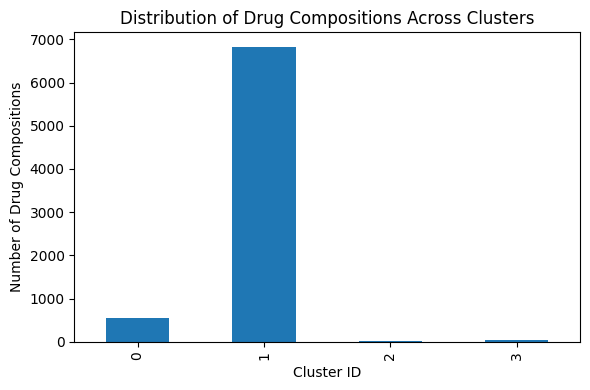

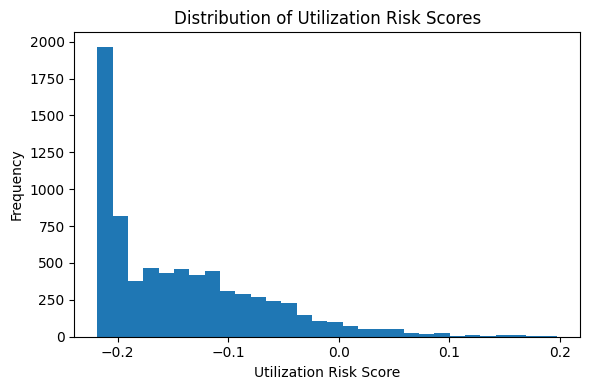

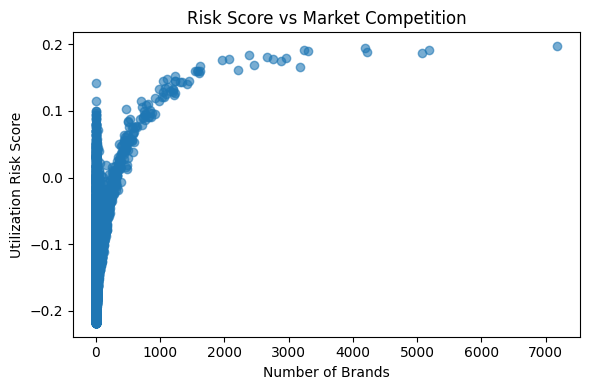

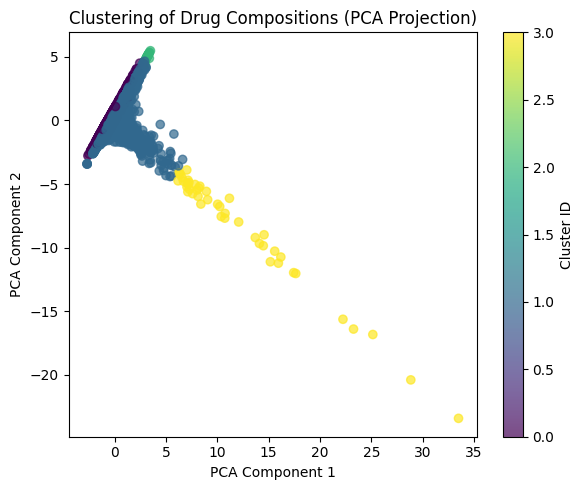

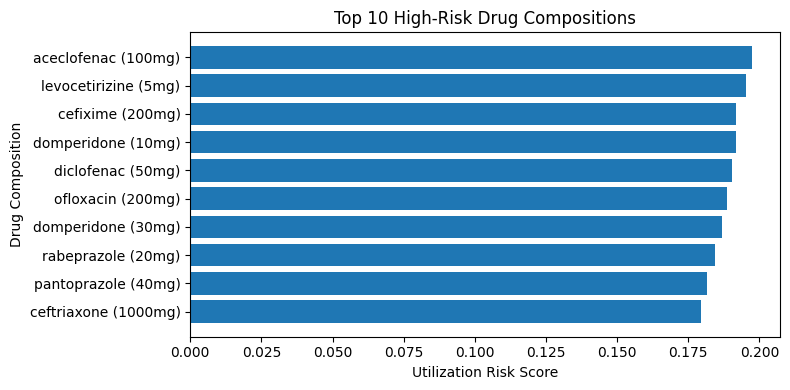


Cluster-wise Utilization Statistics:


,avg_risk_score,avg_price,avg_brands,avg_manufacturers,avg_discontinued_ratio
cluster,,,,,
0,-0.044,1211.729,1.742,1.587,0.827
1,-0.152,1309.354,22.781,19.497,0.031
2,0.020,220564.596,2.312,2.125,0.008
3,0.156,99.006,2076.511,1327.733,0.018


In [33]:
# ================================
# CLUSTERING & UTILIZATION STATS VISUALIZATION
# SINGLE RUN BLOCK (COLAB READY)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------- 1. BASIC SANITY CHECK ----------
required_cols = [
    'cluster', 'risk_score', 'avg_price',
    'brands', 'manufacturers', 'discontinued_ratio'
]

for col in required_cols:
    if col not in ml_df.columns:
        raise ValueError(f"Missing required column: {col}")

# ---------- 2. CLUSTER DISTRIBUTION ----------
plt.figure(figsize=(6,4))
ml_df['cluster'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Drug Compositions")
plt.title("Distribution of Drug Compositions Across Clusters")
plt.tight_layout()
plt.show()

# ---------- 3. RISK SCORE DISTRIBUTION ----------
plt.figure(figsize=(6,4))
plt.hist(ml_df['risk_score'], bins=30)
plt.xlabel("Utilization Risk Score")
plt.ylabel("Frequency")
plt.title("Distribution of Utilization Risk Scores")
plt.tight_layout()
plt.show()

# ---------- 4. RISK SCORE VS COMPETITION ----------
plt.figure(figsize=(6,4))
plt.scatter(ml_df['brands'], ml_df['risk_score'], alpha=0.6)
plt.xlabel("Number of Brands")
plt.ylabel("Utilization Risk Score")
plt.title("Risk Score vs Market Competition")
plt.tight_layout()
plt.show()

# ---------- 5. PCA-BASED CLUSTER VISUALIZATION ----------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=ml_df['cluster'],
    alpha=0.7
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustering of Drug Compositions (PCA Projection)")
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()

# ---------- 6. TOP HIGH-RISK COMPOSITIONS ----------
top_risky = ml_df.sort_values('risk_score', ascending=False).head(10)

plt.figure(figsize=(8,4))
plt.barh(top_risky['composition_1'], top_risky['risk_score'])
plt.xlabel("Utilization Risk Score")
plt.ylabel("Drug Composition")
plt.title("Top 10 High-Risk Drug Compositions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ---------- 7. CLUSTER-WISE STATISTICS TABLE ----------
cluster_stats = (
    ml_df
    .groupby('cluster')
    .agg(
        avg_risk_score=('risk_score', 'mean'),
        avg_price=('avg_price', 'mean'),
        avg_brands=('brands', 'mean'),
        avg_manufacturers=('manufacturers', 'mean'),
        avg_discontinued_ratio=('discontinued_ratio', 'mean')
    )
    .round(3)
)

print("\nCluster-wise Utilization Statistics:")
display(cluster_stats)


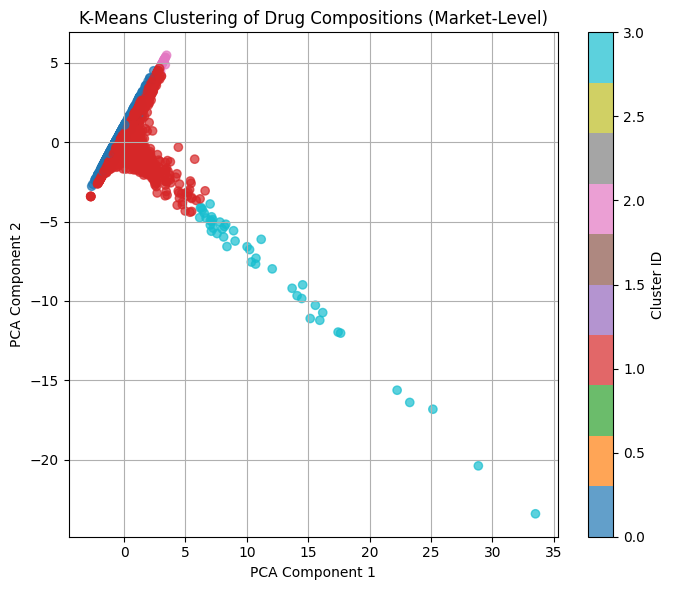

In [34]:
# ================================
# K-MEANS CLUSTER GRAPH (PCA VISUALIZATION)
# ================================

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Safety check
if 'cluster' not in ml_df.columns:
    raise ValueError("Run KMeans first. 'cluster' column not found in ml_df.")

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot K-Means clusters
plt.figure(figsize=(7,6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=ml_df['cluster'],
    cmap='tab10',
    alpha=0.7
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering of Drug Compositions (Market-Level)")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
ml_df['cluster'] = kmeans.fit_predict(X_scaled)
